In [1]:
import pyarrow.dataset as ds
import duckdb
import pandas as pd
from pandas_profiling import ProfileReport
%matplotlib inline


con = duckdb.connect()

dataset = ds.dataset("../../../data/transformed/microdados.parquet", format="parquet", partitioning="hive")
#dataset.schema

/tmp/ipykernel_12710/3150912368.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
df = dataset.to_table().to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608986 entries, 0 to 1608985
Columns: 370 entries, NO_REGIAO to NU_ANO_CENSO
dtypes: bool(210), datetime64[ns](2), int32(114), int64(2), object(42)
memory usage: 1.5+ GB


In [3]:
# executa a função que gera o relatório
profile = ProfileReport(df, title="Censo Escolar", minimal=True)
# visualização do relatório
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

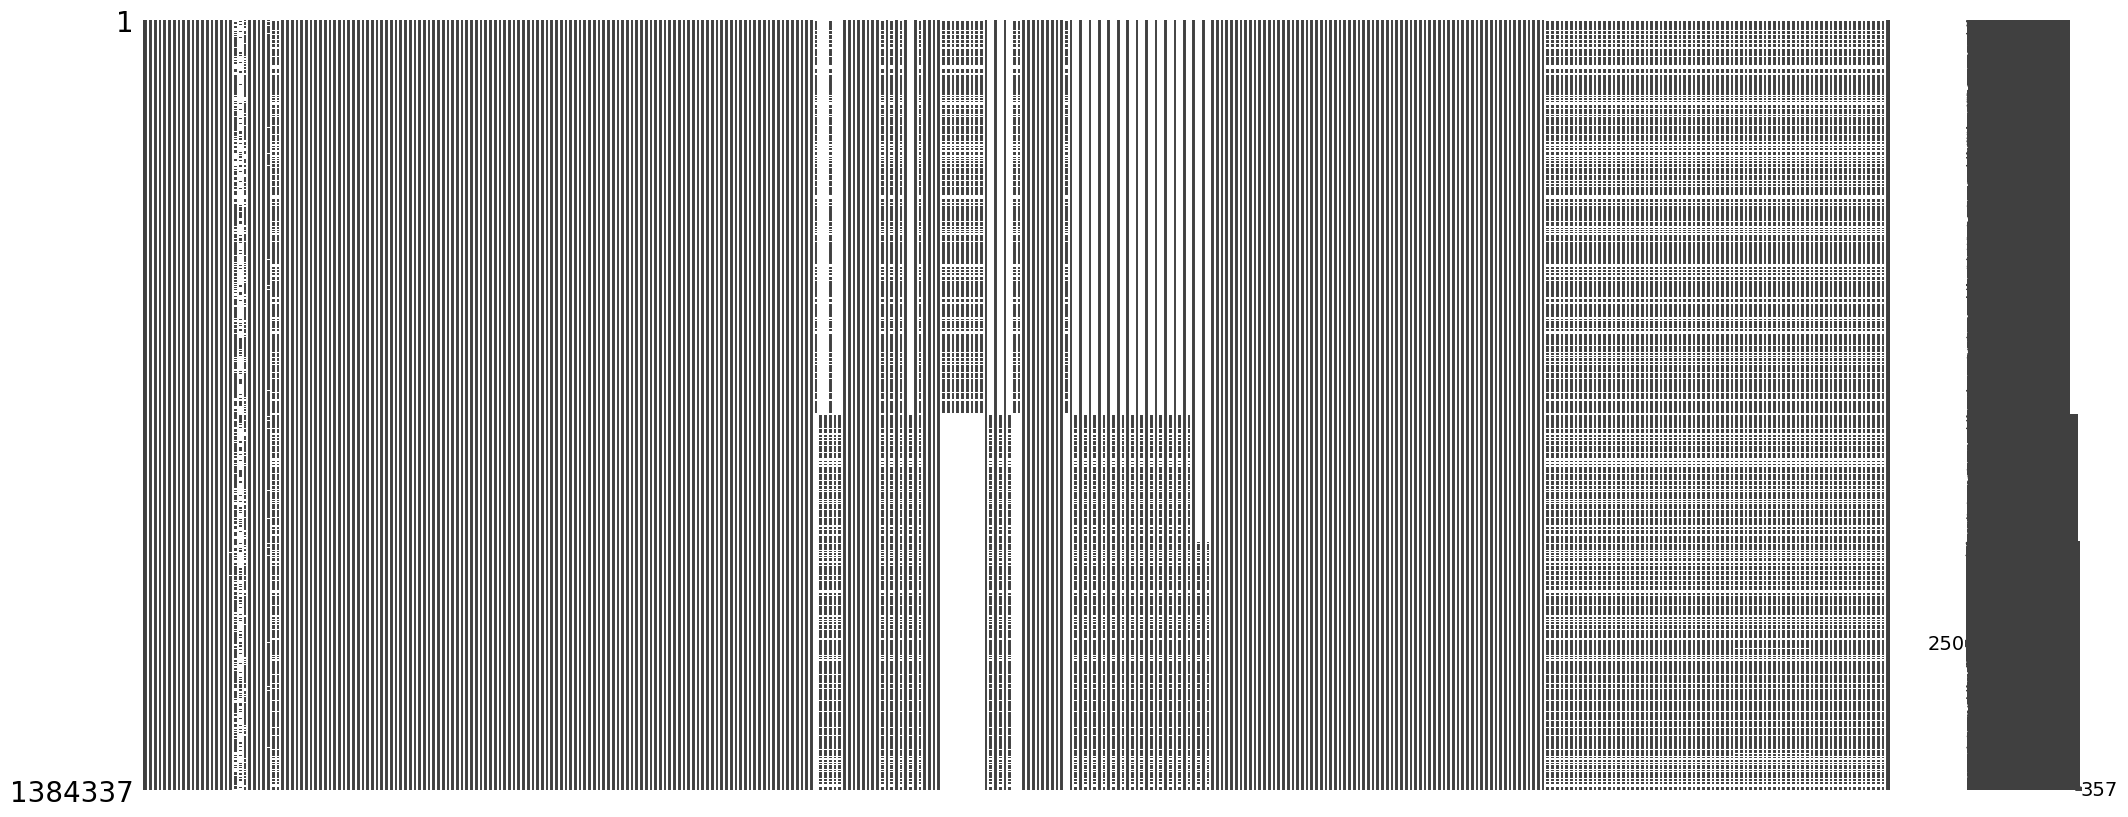

In [5]:
fig = msno.matrix(df)
fig_copy = fig.get_figure()
fig_copy.savefig('missing_values.png', bbox_inches='tight')

In [2]:
con.register("censo", dataset)

In [3]:
volumetry_by_column = con.execute("""
    select
        c.column_name,
        c.data_type,
        (
            case
                when c.data_type = 'VARCHAR' then 2 * 256
                when c.data_type = 'SMALLINT' then 2
                when c.data_type = 'BOOLEAN' then 1
                when c.data_type = 'TIMESTAMP' then 1
                when c.data_type = 'INTEGER' then 4
            end
        ) as "total_size (Bytes)"
    from main.duckdb_columns c
    where c.table_name = 'censo'
    order by c.data_type desc
""").df()
volumetry_by_column.to_csv('../data/volumetry_by_column.csv')
volumetry_by_column

,column_name,data_type,total_size (Bytes)
0,CO_ESCOLA_SEDE_VINCULADA,VARCHAR,512
1,NU_CNPJ_MANTENEDORA,VARCHAR,512
2,NO_UF,VARCHAR,512
3,SG_UF,VARCHAR,512
4,CO_UF,VARCHAR,512
...,...,...,...
365,IN_LOCAL_FUNC_SALAS_EMPRESA,BOOLEAN,1
366,IN_LOCAL_FUNC_PREDIO_ESCOLAR,BOOLEAN,1
367,IN_INTERNET,BOOLEAN,1
368,IN_MANT_ESCOLA_PRIVADA_SIST_S,BOOLEAN,1


In [4]:
volumetry_by_type = con.execute("""
    select
        c.data_type,
        sum(
            case
                when c.data_type = 'VARCHAR' then 2 * 256
                when c.data_type = 'SMALLINT' then 2
                when c.data_type = 'BOOLEAN' then 1
                when c.data_type = 'TIMESTAMP' then 1
                when c.data_type = 'INTEGER' then 4
            end
        ) as "total_size (Bytes)"
    from main.duckdb_columns c
    where c.table_name = 'censo'
    group by c.data_type
    order by c.data_type desc
""").df()
volumetry_by_type.to_csv('../data/volumetry_by_type.csv')
volumetry_by_type

,data_type,total_size (Bytes)
0,VARCHAR,22528.0
1,TIMESTAMP,2.0
2,SMALLINT,226.0
3,INTEGER,4.0
4,BOOLEAN,210.0


In [14]:
mb_per_line = volumetry_by_type["total_size (Bytes)"].sum() * 1e-6
mb_per_line

0.022969999999999997

In [12]:
con.execute(f"""
    select
        NU_ANO_CENSO,
        count(*) as total_rows,
        round(count(*) * {mb_per_line}, 2) as "total_size (MB)"
    from dataset
    group by NU_ANO_CENSO
    order by 1
"""
).df()

,NU_ANO_CENSO,total_rows,total_size (MB)
0,2016,237506,54.56
1,2017,236481,54.32
2,2018,236460,54.31
3,2019,228521,52.49
4,2020,224229,51.51
5,2021,221140,50.80
